In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

%matplotlib inline

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [ ]:
list(raw_data.columns)

In [ ]:
raw_data.rating.describe()

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

In [ ]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [ ]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [ ]:
from sklearn.svm import SVR
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_data.rating
svr.fit(X,Y)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

Now that is a pretty useless visualization. This is because of the discontinous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [ ]:
svr.score(X, Y)

In [ ]:

cross_val_score(svr, X, Y, cv=5)

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

There is something going wrong with this rating data -- Epicurious rates their dishes on a "4-fork" scale, and recipes with zero reviews are the only ones with zero forks. Increments are 1/2 a fork at a time. So what's actually going on here is:

    0.000: no data
    1.250: 1 fork
    1.875: 1.5 forks
    2.500: 2 forks
    3.125: 2.5 forks
    3.750: 3 forks
    4.375: 3.5 forks
    5.000: 4 forks
    
Which means that our regression didn't have a chance with all that bad data, and the weird spacing between classes. We'll get to binary classification, but I'm curious if a well-structured regression would work any better. Let's multiply the "Forks" by two so we're looking at integers, and get rid of all the zeros.

In [5]:
raw_data = raw_data.drop(raw_data[(raw_data['rating']==0)].index)

raw_data['rating'].replace([1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5], [2, 3, 4, 5, 6, 7, 8], inplace=True)

We can separate our rankings into "good" and "bad", but it's hard to choose where to put the boundary line. A natural threshold, I think, would be at 5.5 on our scale from 2 to 8 (this means 2.5 or fewer forks would be "bad", 3, 3.5, and 4 forks would be "good"). This leaves us with skewed classes -- the vast majority of recipes would be "good". 

So another option would be to set the threshold at 6.5, so that only the 3.5 and 4 fork recipes make the cut. This is probably closer to how I would use their website -- only choose the best recipes. Let's see how it works.

In [7]:
raw_bin = raw_data.copy()
raw_bin['rating'] = np.where(raw_bin['rating']>6.5, 1, 0)

And let's resample the data to balance the classes.

In [8]:
neg_df = raw_bin[raw_bin['rating']==0]
pos_df = raw_bin[raw_bin['rating']==1]
print(len(neg_df), len(pos_df))

neg_df_upsamp = resample(neg_df, n_samples=10738)
print(neg_df_upsamp.shape)

raw_bin = pd.concat([neg_df_upsamp, pos_df])

7478 10738
(10738, 680)


In [9]:
raw_bin.shape

(21476, 680)

In [10]:
X = raw_bin.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = raw_bin.rating

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

Let's do some feature selection with SelectKBest and RFC using the most common attributes.

In [24]:
rfc = RandomForestClassifier(max_depth=40)

In [25]:
rfc.fit(X, Y)
Y_pred = rfc.predict(X)
print(rfc.score(X, Y))
print(confusion_matrix(Y, Y_pred))

0.932249953436
[[10181   557]
 [  898  9840]]


In [26]:
cross_val_score(rfc, X, Y, cv=10)

array([ 0.75418994,  0.75232775,  0.74162011,  0.77374302,  0.76769088,
        0.76536313,  0.75139665,  0.76303538,  0.76514445,  0.74743709])

In [92]:
feature_importance = rfc.feature_importances_
sorted_idx = np.argsort(feature_importance)
top_30 = sorted_idx[-30:]

In [93]:
feature_importance[top_30]

array([ 0.00661421,  0.00667007,  0.00671089,  0.00681924,  0.00684168,
        0.00688596,  0.00716489,  0.00719552,  0.00724162,  0.00743689,
        0.00748258,  0.00750003,  0.0075751 ,  0.00773236,  0.00802014,
        0.00822804,  0.0082587 ,  0.0085665 ,  0.00864428,  0.0086774 ,
        0.00870783,  0.00883913,  0.00890231,  0.0090969 ,  0.00928075,
        0.00931331,  0.01049803,  0.01124209,  0.01155352,  0.01268243])

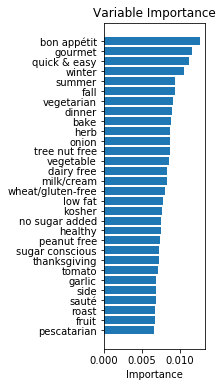

In [94]:
pos = np.arange(feature_importance[top_30].shape[0]) + .5
fig = plt.figure(figsize=(4,6))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[top_30], align='center')
plt.yticks(pos, X.columns[top_30])
plt.xlabel('Importance')
plt.title('Variable Importance')
plt.show()

In [98]:
top_cols = X.columns[top_30]

In [104]:
from sklearn.svm import SVC
svc = SVC(C=1)

In [105]:
svc.fit(X[top_cols],Y)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [106]:
svc.score(X[top_cols],Y)

0.57943751164090151

In [107]:
confusion_matrix(Y, svc.predict(X[top_cols]))

array([[6463, 4275],
       [4757, 5981]])

Well, that's not great. Okay, I suppose -- does about 8% better than random guess. Let's try Select K Best.

In [108]:
skb = SelectKBest(k=30)
skb.fit(X,Y)
X_skb = skb.transform(X)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 14  93 105 161 162 183 201 225 226 234 256 285 302 308 358 369 394 501
 567 643 670] are constant.
  UserWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [110]:
X_skb.shape

(21476, 30)

In [111]:
svc.fit(X_skb,Y)
svc.score(X_skb,Y)

0.57883218476438814

In [112]:
confusion_matrix(Y, svc.predict(X_skb))

array([[6285, 4453],
       [4592, 6146]])

In [117]:
skb_idx = skb.get_support(indices=True)

In [118]:
X.columns[skb_idx]

Index(['backyard bbq', 'banana', 'bon appétit', 'broccoli', 'chile pepper',
       'christmas', 'dessert', 'dinner', 'father's day', 'fourth of july',
       'gourmet', 'grill', 'grill/barbecue', 'low fat', 'low/no sugar',
       'pasta', 'pastry', 'peanut free', 'quick & easy', 'rice', 'roast',
       'sauté', 'side', 'soy free', 'stir-fry', 'stuffing/dressing',
       'thanksgiving', 'tofu', 'vegetable', 'zucchini'],
      dtype='object')

These indices are similar to those found in RFC, and not so different from the ones I found the first time around when I did it by hand. They aren't giving a much better accuracy, either -- about 58%. Let's try with the top 50 features and call it good.

In [119]:
skb = SelectKBest(k=50)
skb.fit(X,Y)
X_skb = skb.transform(X)

svc.fit(X_skb,Y)
svc.score(X_skb,Y)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 14  93 105 161 162 183 201 225 226 234 256 285 302 308 358 369 394 501
 567 643 670] are constant.
  UserWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.59005401378282729

In [120]:
skb = SelectKBest(k=100)
skb.fit(X,Y)
X_skb = skb.transform(X)

svc.fit(X_skb,Y)
svc.score(X_skb,Y)

/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 14  93 105 161 162 183 201 225 226 234 256 285 302 308 358 369 394 501
 567 643 670] are constant.
  UserWarning)
/Users/maxcalabro/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


0.60234680573663624

It seems like Random Forest may have been a better model for this dataset. It got up to 78% accuracy on cross validation using the whole dataset, and runs substantially faster than SVC, even with more features included. 